In [2]:

import numpy as np
import torchvision
from torchvision.transforms import v2
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import skimage.color
# Construct a tf.data.Dataset

/cs/cs152/venv/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/cs/cs152/venv/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue:

In [3]:

def split_norm(lab_img):
    # return lab_img[:][0]/50 - 1, lab_img[:][1, 2]/120
    # return torch.select(lab_img, 1, 0)
    
    return torch.unsqueeze(lab_img[:, 0, :, :]/50 - 1, 1), lab_img[:, (1,2), :, :]/100

def merge_denorm(l, ab):
    # return lab_img[:][0]/50 - 1, lab_img[:][1, 2]/120
    # return torch.select(lab_img, 1, 0)
    l = (l + 1)*50
    ab = ab*100
    return torch.cat((l, ab), 1)

In [4]:

transform = v2.Compose(
    [

     
     v2.Resize((80, 80)), v2.ToTensor()],
     
    )


transform_grey = v2.Compose(
    [

     # v2.ToPILImage(),
     v2.Grayscale(),
     # v2.ToTensor()
    ],
    )



training_set = torchvision.datasets.LFWPeople('/cs/cs152/individual/treddy/celeb', split='train', transform=transform, download=True)
validation_set = torchvision.datasets.LFWPeople('/cs/cs152/individual/treddy/celeb2', split='test', transform=transform, download=True)
# training_set = torchvision.datasets.OxfordIIITPet('/cs/cs152/individual/treddy/pet', split='trainval', transform=transform, download=True)
# validation_set = torchvision.datasets.OxfordIIITPet('/cs/cs152/individual/treddy/pet2', split='test', transform=transform, download=True)


/cs/cs152/venv/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


tensor(1.)
tensor(0.)


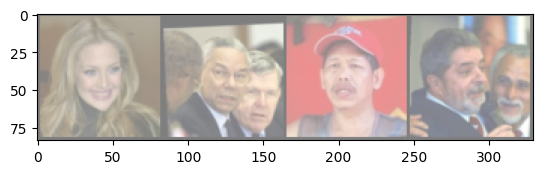

In [7]:

training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)



# copied from pytorch docs
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        print('1c')
        plt.imshow(npimg, cmap="Greys")
    else:
        # print('a')
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(training_loader)
images, labels = next(dataiter)

print(torch.max(images))
print(torch.min(images))



img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=False)


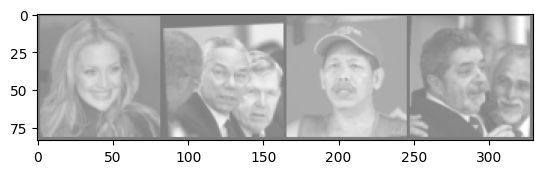

In [8]:
gimages = transform_grey(images)
img_grid = torchvision.utils.make_grid(gimages)
matplotlib_imshow(img_grid, one_channel=False)

In [9]:
from torch.nn.functional import relu, tanh, sigmoid


# NOTE: This UNet was more or less copied from 
# https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
class UNet(nn.Module):
  def __init__(self):
    super().__init__()

    # input is a 64x64x1
    self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # out = 64x64x64
    self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # out = 32x32x64

    self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output = 32x32x128
    self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 32x32x128
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output= 16x16x128

    self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output= 16x16x256
    self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) #
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 8x8x256

    self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output 8x8x512
    self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) #4x4x512

    self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
    self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


    self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
    self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
    self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

    self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
    self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

    self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
    self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

    self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
    self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

    self.outconv = nn.Conv2d(64, 3, kernel_size=1)


  def forward(self, x):
    out_e11 = relu(self.e11(x))
    out_e12 = relu(self.e12(out_e11))
    out_ep1 = self.pool1(out_e12)

    out_e21 = relu(self.e21(out_ep1))
    out_e22 = relu(self.e22(out_e21))
    out_p2 = self.pool2(out_e22)

    out_e31 = relu(self.e31(out_p2))
    out_e32 = relu(self.e32(out_e31))
    out_p3 = self.pool3(out_e32)

    out_e41 = relu(self.e41(out_p3))
    out_e42 = relu(self.e42(out_e41))
    out_p4 = self.pool3(out_e42)

    out_e51 = relu(self.e51(out_p4))
    out_e52 = relu(self.e52(out_e51))


        # Decoder
    out_u1 = self.upconv1(out_e52)
    # print(out_u1.shape)
    # print(out_e42.shape)
    out_u11 = torch.cat([out_u1, out_e42], dim=1)
    out_d11 = relu(self.d11(out_u11))
    out_d12 = relu(self.d12(out_d11))

    out_u2 = self.upconv2(out_d12)
    out_u22 = torch.cat([out_u2, out_e32], dim=1)
    out_d21 = relu(self.d21(out_u22))
    out_d22 = relu(self.d22(out_d21))

    out_u3 = self.upconv3(out_d22)
    out_u33 = torch.cat([out_u3, out_e22], dim=1)
    out_d31 = relu(self.d31(out_u33))
    out_d32 = relu(self.d32(out_d31))

    out_u4 = self.upconv4(out_d32)
    out_u43 = torch.cat([out_u4, out_e12], dim=1)
    out_d41 = relu(self.d41(out_u43))
    out_d42 = relu(self.d42(out_d41))

    #
        # Output layer
    out = self.outconv(out_d42)
    # out = sigmoid(out1)

    return out



In [10]:

model = UNet()
model.to(device)
loss_fn = torch.nn.L1Loss()

# optimizer = torch.optim.RMSprop(params = model.parameters(), lr=0.000001, )
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.000001 )



In [11]:
# taken from pytorch docs and modified
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

  
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        colored, _ = data
        colored = colored.cuda()
      
        grey = transform_grey(colored)
      
        optimizer.zero_grad()

        outputs = model(grey)
        # print(outputs.shape)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, colored)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 200 == 199:
            last_loss = running_loss / 200 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))

            running_loss = 0.

    return last_loss

In [12]:
# taken from pytorch docs and modified
epoch_number = 0

EPOCHS = 60

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train(True)
    avg_loss = train_one_epoch(epoch_number)


    running_vloss = 0.0

    model.eval()


    with torch.no_grad():
        # for i, vdata in enumerate(validation_loader):
        for i, vdata in enumerate(validation_loader):
            # vinputs, vlabels = vdata
            vcolored, vlabels = vdata
            vcolored = vcolored.cuda()
            vgrey = transform_grey(vcolored)
            voutputs = model(vgrey)
            vloss = loss_fn(voutputs, vcolored)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))


    if avg_vloss < best_vloss:
        best_vloss = avg_vloss

    epoch_number += 1

EPOCH 1:
  batch 200 loss: 0.4570224949717522


KeyboardInterrupt: 

In [ ]:
colored, labels = next(dataiter)

grey = transform_grey(colored)

abs = model(grey.cuda())




# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(abs.cpu())
matplotlib_imshow(img_grid, one_channel=False)

In [ ]:
img_grid = torchvision.utils.make_grid(colored.cpu())
matplotlib_imshow(img_grid, one_channel=False)

In [ ]:
img_grid = torchvision.utils.make_grid(grey)
matplotlib_imshow(img_grid, one_channel=False)

In [ ]:
torch.save(model, "'modelrgb2.pt'")